# Extra Point and Two Point Conversion Models
Note that all models here exclude overtime

In [ ]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_error
import shap
from sklearn.metrics import log_loss

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [5]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [367]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [368]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412710,2013,1,regular,True,False,3746.0,2013-08-29 23:00:00+00:00,2710,Western Illinois,MVFC,fcs,42.0,NaN,2261,Hampton,MEAC,fcs,9.0,NaN
4,332412050,2013,1,regular,True,False,3919.0,2013-08-29 23:00:00+00:00,2050,Ball State,Mid-American,fbs,51.0,NaN,2287,Illinois State,MVFC,fcs,28.0,NaN


In [369]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [370]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    venues = pd.DataFrame([val.to_dict() for val in data])
    venues.columns = convert_to_snake_case(venues.columns)
    venues.to_parquet(file_path)

venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [371]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,1,21
1,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,1,31
2,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,34,66,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,0,50
3,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,31,4,0.0,2.0,28,72,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,1,35
4,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,63,37,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,4,0


In [372]:
# Load drives data
all_dfs = []

drives_dir = join(DATA_DIR, "drives")
if not os.path.exists(drives_dir):
    os.makedirs(drives_dir)

for year in YEARS:
    season_file_path = join(drives_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        season_drives = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching {year} drives data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.DrivesApi(api_client)
            data = api_instance.get_drives(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)

        tmp["start_time_minutes"] = tmp["start_time"].apply(lambda x: x["minutes"])
        tmp["start_time_seconds"] = tmp["start_time"].apply(lambda x: x["seconds"])
        tmp["end_time_minutes"] = tmp["end_time"].apply(lambda x: x["minutes"])
        tmp["end_time_seconds"] = tmp["end_time"].apply(lambda x: x["seconds"])
        tmp.drop(columns=["start_time","end_time"], inplace=True)

        season_drives = tmp.copy()
                
        season_drives.to_parquet(season_file_path)
        print(f"Saved drives data for {year} to {season_file_path}")

    all_dfs.append(season_drives)
    
drives = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
drives.head()

Reading ../data/drives/2013.parquet from cached data
Reading ../data/drives/2014.parquet from cached data
Reading ../data/drives/2015.parquet from cached data
Reading ../data/drives/2016.parquet from cached data
Reading ../data/drives/2017.parquet from cached data
Reading ../data/drives/2018.parquet from cached data
Reading ../data/drives/2019.parquet from cached data
Reading ../data/drives/2020.parquet from cached data
Reading ../data/drives/2021.parquet from cached data
Reading ../data/drives/2022.parquet from cached data
Reading ../data/drives/2023.parquet from cached data
Reading ../data/drives/2024.parquet from cached data


,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000601,1,False,1,25,75,1,36,64,6,11,PUNT,True,0,0,0,0,15,0,11,55
1,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000602,2,True,1,77,77,1,16,16,12,61,FG GOOD,False,0,0,3,0,11,55,5,52
2,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000603,3,False,1,48,52,1,76,24,9,28,FG MISSED,True,0,3,0,3,5,52,2,21
3,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000604,4,True,1,76,76,1,0,0,3,76,RUSHING TD,False,3,0,10,0,2,21,1,16
4,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000605,5,False,1,25,75,2,45,55,5,20,PUNT,True,0,10,0,10,1,16,14,53


In [373]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elo.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


# 1. Decision Model
Extra Point Attemt or Two-Point Conversion Attempt

In [374]:
try_attempt_types = ['Extra Point Good', 'Extra Point Missed', '2pt Conversion', 'Two Point Pass','Two Point Rush']
try_attempts = plays[
    plays['play_type'].isin(try_attempt_types) |
    plays['play_text'].str.lower().str.contains("two-point", na=False) |
    plays['play_text'].str.lower().str.contains("extra point", na=False)
].copy()
try_attempts['extra_point_attempt'] = np.where(
    try_attempts['play_type'].isin(['Extra Point Good', 'Extra Point Missed']) |
    try_attempts['play_text'].str.lower().str.contains("extra point", na=False),
    True, False
)
try_attempts = (
    try_attempts
    .merge(
        drives[['id', 'game_id', 'start_offense_score', 'end_offense_score']].rename(
            columns={'id': 'drive_id'}
        ),
        on=['drive_id', 'game_id'],
        how='left'
    )
    .assign(
        try_points_scored = lambda x: x.end_offense_score - x.start_offense_score - 6
    )
    .query('(extra_point_attempt & try_points_scored.isin([0, 1])) or '
           '(~extra_point_attempt & try_points_scored.isin([0, 2]))')
)
try_attempts = (
    try_attempts
    .assign(
        score_diff_before = try_attempts.offense_score - try_attempts.defense_score - try_attempts.try_points_scored,
        pct_game_played = (((try_attempts['period'] - 1) * 15 * 60) + ((15 * 60) - 
                            (try_attempts['clock_minutes'] * 60 + try_attempts['clock_seconds']))) / (4 * 15 * 60),
        game_seconds_remaining = ((4 * 15 * 60) - ((try_attempts['period'] - 1) * 15 * 60 + (15 * 60) - 
                                (try_attempts['clock_minutes'] * 60 + try_attempts['clock_seconds']))),
    )
)

def can_tie_with_3_and_7_one_fg(diff):
    target = -diff
    for fg in [0, 1]:  # 0 or 1 field goals (not allowing for more than 1 FG)
        for td in range((target - 3 * fg) // 7 + 1):
            if 7 * td + 3 * fg == target:
                return True
    return False

def can_tie_with_3_7_8_one_fg(diff):
    target = -diff
    for fg in [0, 1]:  # 0 or 1 field goals
        for td_8 in range((target - 3 * fg) // 8 + 1):
            for td_7 in range((target - 3 * fg - 8 * td_8) // 7 + 1):
                if 8 * td_8 + 7 * td_7 + 3 * fg == target:
                    return True
    return False

def special_tie_condition(diff):
    if diff >= 0:
        return False  # not trailing
    return (
        not can_tie_with_3_and_7_one_fg(diff)
        and can_tie_with_3_7_8_one_fg(diff)
    )

try_attempts = (
    try_attempts
    .assign(
        diff_time_ratio = try_attempts['score_diff_before'] * np.exp(4 * (3600 - try_attempts['game_seconds_remaining']) / 3600),
        two_point_to_tie = np.where(try_attempts.score_diff_before == -2, True, False),
        two_point_to_lead = np.where(try_attempts.score_diff_before == -1, True, False),
        will_need_two_pt_to_tie = try_attempts.apply(
            lambda row: special_tie_condition(row['score_diff_before'] - 6),
            axis=1
        )
    )
    .query('period.isin([1, 2, 3, 4]) and 0 <= pct_game_played <= 1') # No overtime attempts
    [['score_diff_before', 'pct_game_played', 'period', 'diff_time_ratio',
      'two_point_to_tie', 'two_point_to_lead',
      'will_need_two_pt_to_tie', 'extra_point_attempt']]
)
try_attempts.head()

,score_diff_before,pct_game_played,period,diff_time_ratio,two_point_to_tie,two_point_to_lead,will_need_two_pt_to_tie,extra_point_attempt
0,-1,0.193056,1,-2.164571,False,True,False,True
1,2,0.751111,4,40.350009,False,False,False,True
2,29,0.478889,2,196.930601,False,False,False,True
3,16,0.370556,2,70.443498,False,False,False,True
4,16,0.251667,2,43.783428,False,False,False,True


In [375]:
features = [
    'score_diff_before', 
    'pct_game_played', 
    'diff_time_ratio',
    'two_point_to_tie', 
    'two_point_to_lead', 
    'will_need_two_pt_to_tie'
]

data = try_attempts[features + ['extra_point_attempt']].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data['extra_point_attempt']
)
test_x, test_y = test_data[features], test_data['extra_point_attempt']

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[features], 
    train_data['extra_point_attempt'], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data['extra_point_attempt']
)

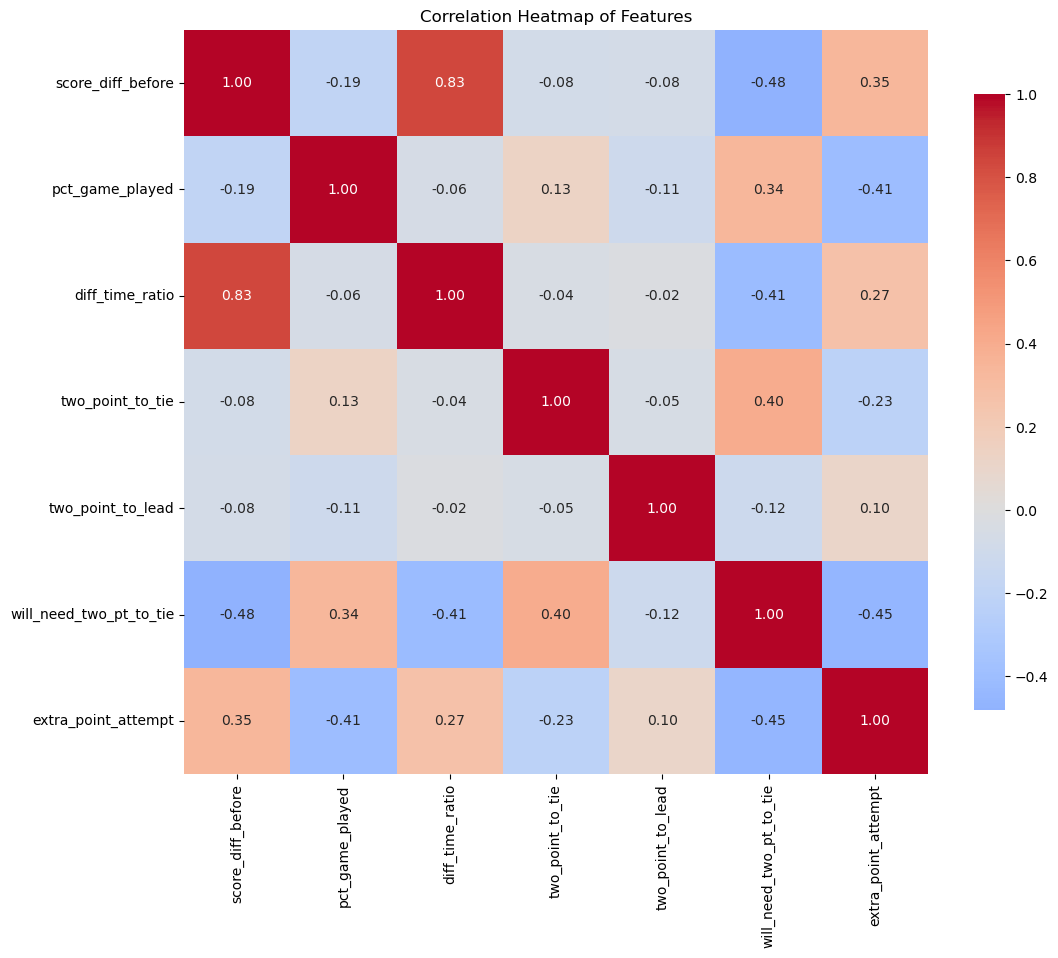

In [376]:
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [377]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

feature_names = [
    'score_diff_before', 
    'pct_game_played', 
    'diff_time_ratio',
    'two_point_to_tie', 
    'two_point_to_lead', 
    'will_need_two_pt_to_tie'
]

# interaction_constraints = [
#     ['will_need_two_pt_to_tie', 'pct_game_played'],
#     ['two_point_to_lead', 'pct_game_played'],
#     ['two_point_to_tie', 'pct_game_played'],
# ]

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        # "interaction_constraints": interaction_constraints,
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="try_attempts_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    # 'interaction_constraints': interaction_constraints,
    'eval_metric': 'logloss',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

# Evaluate on train set
train_preds = final_model.predict(dtrain)
print(f"Final train log loss: {log_loss(train_y, train_preds):0.3f}")

# Evaluate on validation set
valid_preds = final_model.predict(dvalid)
print(f"Final validation log loss: {log_loss(valid_y, valid_preds):0.3f}")

# Evaluate on test set
dtest = xgb.DMatrix(test_x, label= test_y)
test_preds = final_model.predict(dtest)
print(f"Final test log loss: {log_loss(test_y, test_preds):0.3f}")

Number of boosted rounds: 64
Final train log loss: 0.326
Final validation log loss: 0.354
Final test log loss: 0.378


In [385]:
p = try_attempts.extra_point_attempt.value_counts(normalize=True).values[0]
baseline_log_loss = -(p * np.log(p) + (1 - p) * np.log(1 - p))
print(f"Baseline probability of extra point attempt: {p:0.3f}")
print(f"Baseline log loss: {baseline_log_loss:0.3f}")

Baseline probability of extra point attempt: 0.622
Baseline log loss: 0.663


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_48013/10610399.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


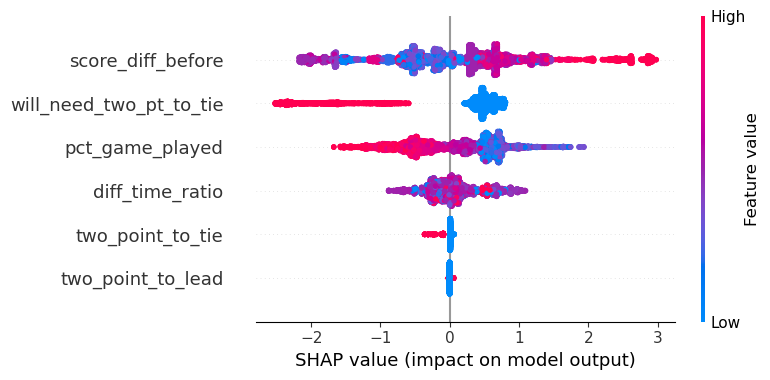

In [379]:
import shap
background = train_data[feature_names]
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, 
                 background, 
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

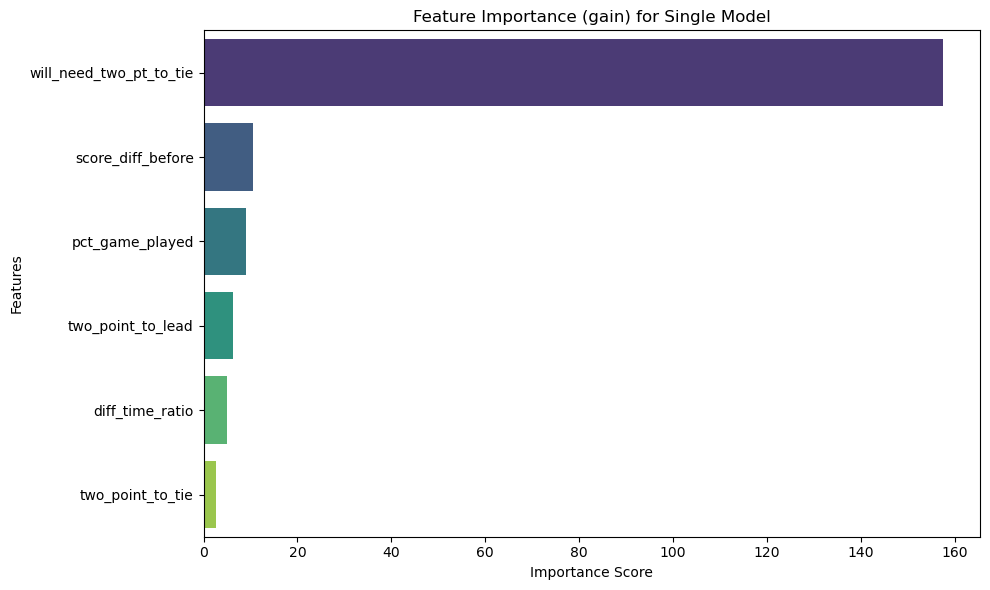

In [380]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [381]:
# predict extra_point_attempt_proba for all plays
try_attempts['extra_point_attempt_proba'] = final_model.predict(xgb.DMatrix(try_attempts[feature_names]))

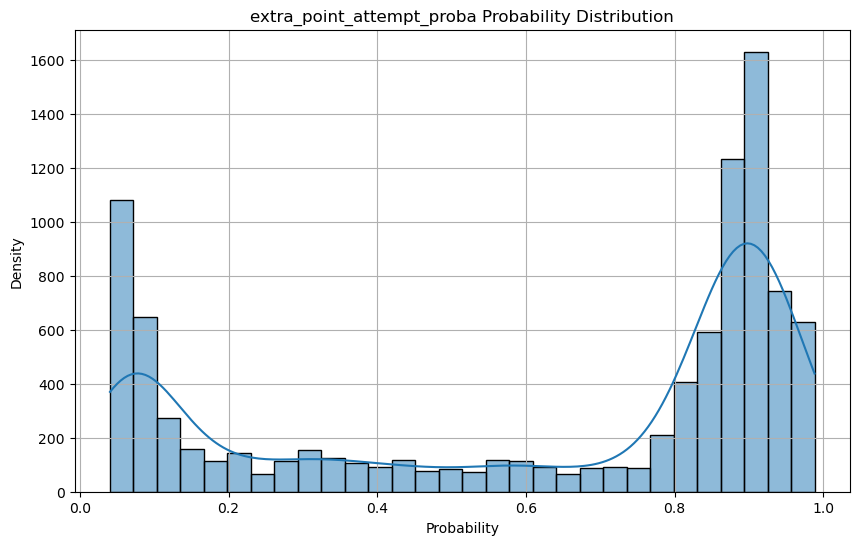

In [382]:
# plot win probability
def plot_wp(df, col):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(try_attempts, col='extra_point_attempt_proba')

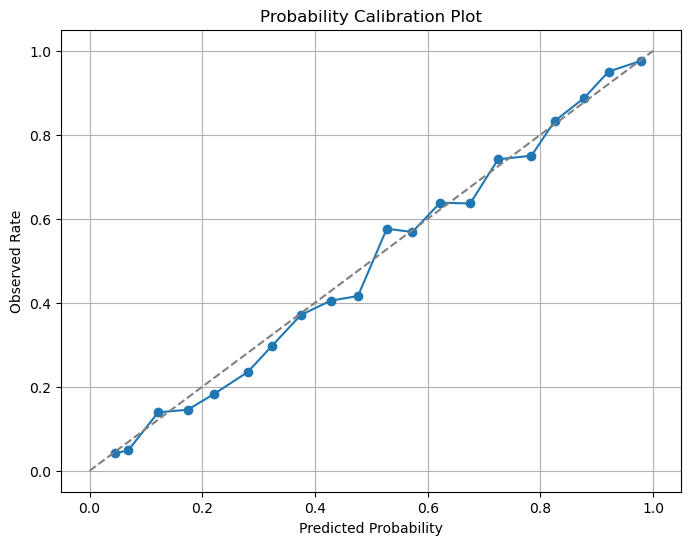

In [383]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(try_attempts, proba_col='extra_point_attempt_proba', actual_col='extra_point_attempt', bins=20)

In [384]:
model_dir = join('../models/raw', 'try_attempt')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, f"decision_classifier_xgb.bin")
final_model.save_model(model_path)

print(f"Saved model to the '{model_dir}' folder.")

Saved model to the '../models/raw/try_attempt' folder.


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_48013/2666871428.py:6: UserWarning: [02:19:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  final_model.save_model(model_path)


# 2. Extra Point Research
Extra point model performs poorly, low correlations to features. It fails to significanly outperform a baseline model with always chooses the majority class (XP make). Because of this, I went with the simpler route of sampleing from empirical base rates binned by division + a binary of if they are in a Power 5 conference or not.

In [283]:
extra_point_types = ['Extra Point Good', 'Extra Point Missed']
xp_attempts = plays[
    plays['play_type'].isin(extra_point_types) |
    plays['play_text'].str.lower().str.contains("extra point", na=False)
].copy()
xp_attempts = (
    xp_attempts
    .merge(
        drives[['id', 'game_id', 'start_offense_score', 'end_offense_score']].rename(
            columns={'id': 'drive_id'}
        ),
        on=['drive_id', 'game_id'],
        how='left'
    )
    .assign(
        extra_point_good = lambda x: x.end_offense_score - x.start_offense_score - 6
    )
    .query('extra_point_good.isin([0, 1])')

)
xp_attempts = (
    xp_attempts
    .assign(
        score_diff_before = xp_attempts.offense_score - xp_attempts.defense_score - xp_attempts.extra_point_good,
        pct_game_played = (((xp_attempts['period'] - 1) * 15 * 60) + ((15 * 60) - 
                            (xp_attempts['clock_minutes'] * 60 + xp_attempts['clock_seconds']))) / (4 * 15 * 60),
        game_seconds_remaining = ((4 * 15 * 60) - ((xp_attempts['period'] - 1) * 15 * 60 + (15 * 60) - 
                                (xp_attempts['clock_minutes'] * 60 + xp_attempts['clock_seconds']))),
    )
    .merge(
        weather[['id','temperature','wind_speed','precipitation','game_indoors']].rename(
            columns={'id': 'game_id'}
        ),
        on='game_id',
        how='left'
    )
    .merge(
        games[['id','season','week','venue_id']].rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'division', 'elo']].rename(columns={
            'team': 'offense', 
            'elo': 'offense_elo',
            'division': 'offense_division'
        }),
        on=['season', 'week', 'offense'],
        how='left'
    )
    .merge(
        venues[['id', 'elevation']].rename(columns={'id': 'venue_id'}),
        on='venue_id',
        how='left'
    ).drop(columns=['venue_id'])
)
xp_attempts['elevation'] = xp_attempts['elevation'].astype(float)

xp_attempts = (
    xp_attempts
    .assign(
        wind_speed = np.where(xp_attempts.game_indoors, 0, xp_attempts.wind_speed.fillna(int(xp_attempts.wind_speed.mean()))),
        elevation = xp_attempts.elevation.fillna(int(xp_attempts.elevation.astype(float).mean())),
        precipitation = np.where(xp_attempts.game_indoors, 0, xp_attempts.precipitation.fillna(int(xp_attempts.precipitation.mean()))),
        temperature = np.where(xp_attempts.game_indoors, 70, xp_attempts.temperature.fillna(int(xp_attempts.temperature.mean()))),
        must_make_to_stay_alive = np.where(
            (xp_attempts.score_diff_before == -1) & (xp_attempts.game_seconds_remaining <= 120),
            True,
            False
        ),
        xp_ties_game = np.where(
            xp_attempts.score_diff_before == -1,
            True,
            False
        ),
        xp_for_lead = np.where(
            xp_attempts.score_diff_before == 0,
            True,
            False
        ),
        is_home_team = np.where(
            xp_attempts.offense == xp_attempts.home,
            True,
            False
        ),
        diff_time_ratio = xp_attempts['score_diff_before'] * np.exp(4 * (3600 - xp_attempts['game_seconds_remaining']) / 3600),
    )
    .drop(columns=['game_indoors'])
    .query('period.isin([1, 2, 3, 4]) and 0 <= pct_game_played <= 1') # No overtime attempts
)

xp_attempts.head()

,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,start_offense_score,end_offense_score,extra_point_good,score_diff_before,pct_game_played,game_seconds_remaining,temperature,wind_speed,precipitation,season,week,offense_division,offense_elo,elevation,must_make_to_stay_alive,xp_ties_game,xp_for_lead,is_home_team,diff_time_ratio
0,333610120047,33361012006,333610120,6,8,Maryland,ACC,7,Marshall,Maryland,Marshall,Conference USA,7,1,3.0,3.0,97,3,-1,-1,0,True,Extra Point Good,Brad Craddock extra point GOOD.,NaN,3,25,0,7,1,-1,0.193056,2905,46.0,9.2,0.0,2013,1,fbs,1921.246102,10.749901,False,True,False,True,-2.164571
1,333610120189,33361012018,333610120,18,17,Maryland,ACC,20,Marshall,Maryland,Marshall,Conference USA,17,4,3.0,3.0,97,3,-1,-1,0,True,Extra Point Good,Brad Craddock extra point GOOD.,NaN,14,56,13,20,1,2,0.751111,896,46.0,9.2,0.0,2013,1,fbs,1921.246102,10.749901,False,False,False,True,40.350009
2,332430120132,33243012015,332430120,15,8,Maryland,ACC,40,Florida International,Maryland,Florida International,Conference USA,10,2,2.0,3.0,97,3,-1,-1,0,True,Extra Point Good,Brad Craddock extra point GOOD.,NaN,1,16,33,40,1,29,0.478889,1876,87.4,4.7,0.0,2013,1,fbs,1921.246102,32.687481,False,False,False,True,196.930601
3,332430120084,33243012011,332430120,11,3,Maryland,ACC,26,Florida International,Maryland,Florida International,Conference USA,10,2,2.0,3.0,97,3,-1,-1,0,False,Extra Point Missed,Brad Craddock extra point MISSED.,NaN,7,46,20,26,0,16,0.370556,2266,87.4,4.7,0.0,2013,1,fbs,1921.246102,32.687481,False,False,False,True,70.443498
4,332430120052,33243012007,332430120,7,9,Maryland,ACC,20,Florida International,Maryland,Florida International,Conference USA,3,2,2.0,3.0,97,3,-1,-1,0,True,Extra Point Good,Brad Craddock extra point GOOD.,NaN,14,54,13,20,1,16,0.251667,2694,87.4,4.7,0.0,2013,1,fbs,1921.246102,32.687481,False,False,False,True,43.783428


In [284]:
features = [
    'score_diff_before',
    'pct_game_played', 
    'diff_time_ratio',
    'temperature',
    'wind_speed', 
    'precipitation', 
    'elevation', 
    'offense_elo',
    'must_make_to_stay_alive', 
    'xp_ties_game', 
    'xp_for_lead',
    'is_home_team'
]

data = xp_attempts[features + ['extra_point_good']].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data['extra_point_good']
)
test_x, test_y = test_data[features], test_data['extra_point_good']

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[features], 
    train_data['extra_point_good'], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data['extra_point_good']
)

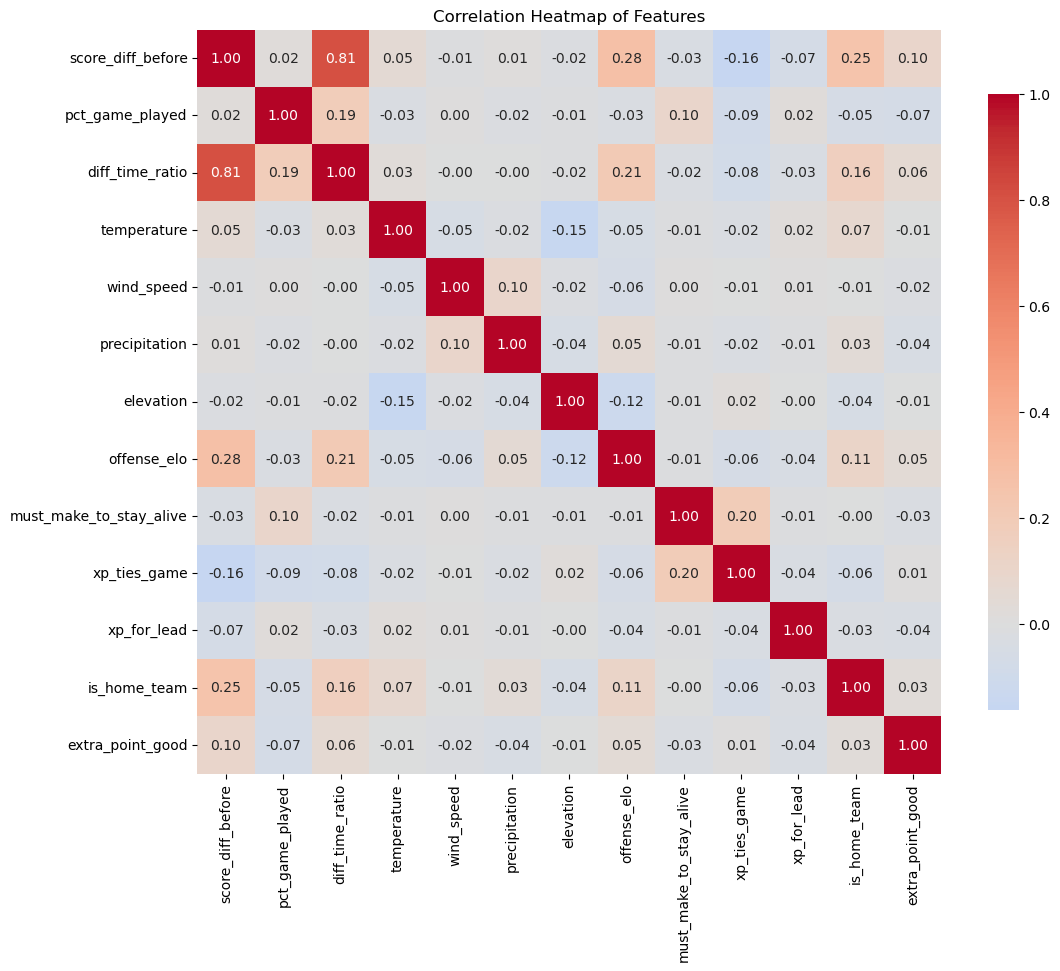

In [285]:
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [286]:
train_x.head()

,score_diff_before,pct_game_played,diff_time_ratio,temperature,wind_speed,precipitation,elevation,offense_elo,must_make_to_stay_alive,xp_ties_game,xp_for_lead,is_home_team
1131,17,0.580278,173.178777,61.0,4.7,0.00,231.650085,1749.349924,False,False,False,True
4571,-12,0.372500,-53.245146,51.8,10.3,0.11,742.153015,3350.085225,False,False,False,False
4694,13,0.067778,17.048470,33.8,0.0,0.00,66.907448,2437.688525,False,False,False,False
2191,6,0.093611,8.725100,85.8,3.4,0.00,64.527267,1446.357911,False,False,False,True
3535,13,0.058889,16.452952,48.0,8.1,0.00,197.533768,3087.606970,False,False,False,False


In [265]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

feature_names = [
    'score_diff_before',
    'pct_game_played', 
    'diff_time_ratio',
    'temperature',
    'wind_speed', 
    'precipitation', 
    'elevation', 
    'offense_elo',
    'must_make_to_stay_alive', 
    'xp_ties_game', 
    'xp_for_lead',
    'is_home_team'
]

# interaction_constraints = [
#     ['will_need_two_pt_to_tie', 'pct_game_played'],
#     ['two_point_to_lead', 'pct_game_played'],
#     ['two_point_to_tie', 'pct_game_played'],
# ]

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        # "interaction_constraints": interaction_constraints,
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="xp_attempts_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    # 'interaction_constraints': interaction_constraints,
    'eval_metric': 'logloss',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

# Evaluate on train set
train_preds = final_model.predict(dtrain)
print(f"Final train log loss: {log_loss(train_y, train_preds):0.3f}")

# Evaluate on validation set
valid_preds = final_model.predict(dvalid)
print(f"Final validation log loss: {log_loss(valid_y, valid_preds):0.3f}")

# Evaluate on test set
dtest = xgb.DMatrix(test_x, label= test_y)
test_preds = final_model.predict(dtest)
print(f"Final test log loss: {log_loss(test_y, test_preds):0.3f}")

Number of boosted rounds: 24
Final train log loss: 0.176
Final validation log loss: 0.196
Final test log loss: 0.203


In [386]:
p = xp_attempts.extra_point_good.value_counts(normalize=True).values[0]
baseline_log_loss = -(p * np.log(p) + (1 - p) * np.log(1 - p))
print(f"Baseline probability of extra point good: {p:0.3f}")
print(f"Baseline log loss: {baseline_log_loss:0.3f}")

Baseline probability of extra point good: 0.948
Baseline log loss: 0.204


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_48013/10610399.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


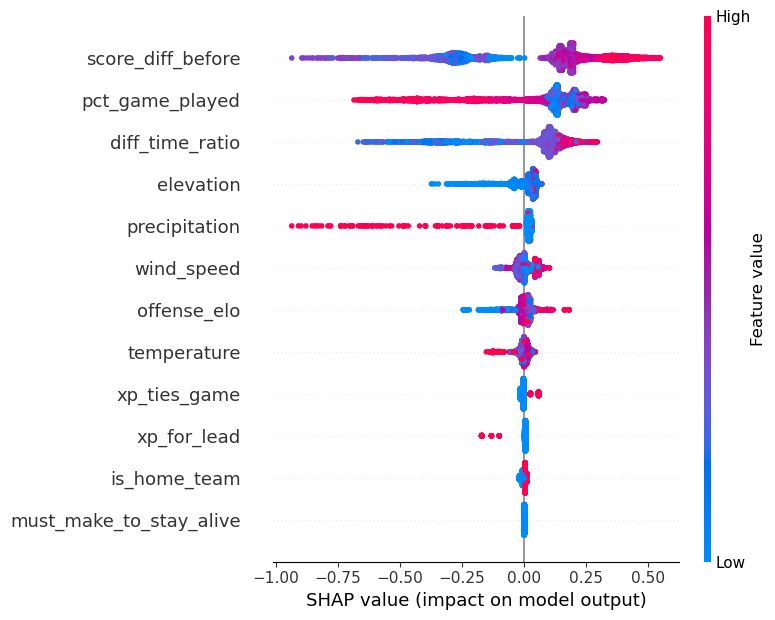

In [267]:
import shap
background = train_data[feature_names]
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, 
                 background, 
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

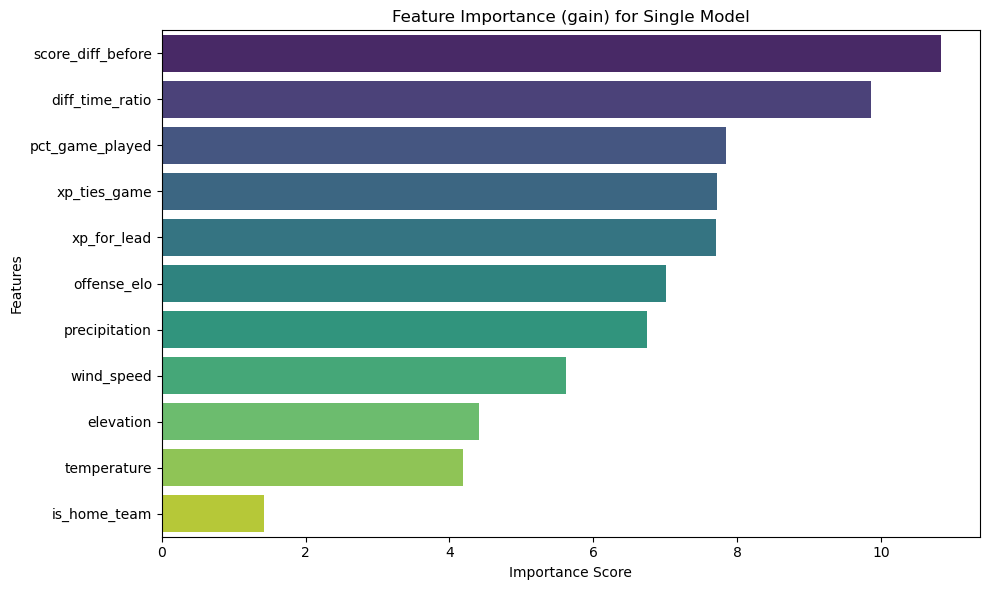

In [268]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [272]:
# predict extra_point_attempt_proba for all plays
xp_attempts['extra_point_make_proba'] = final_model.predict(xgb.DMatrix(xp_attempts[feature_names]))

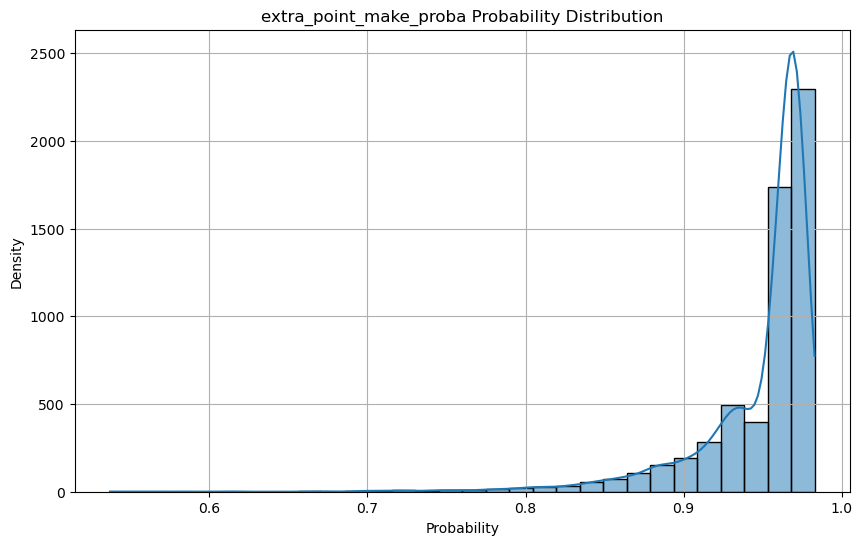

In [273]:
# plot win probability
def plot_wp(df, col):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(xp_attempts, col='extra_point_make_proba')

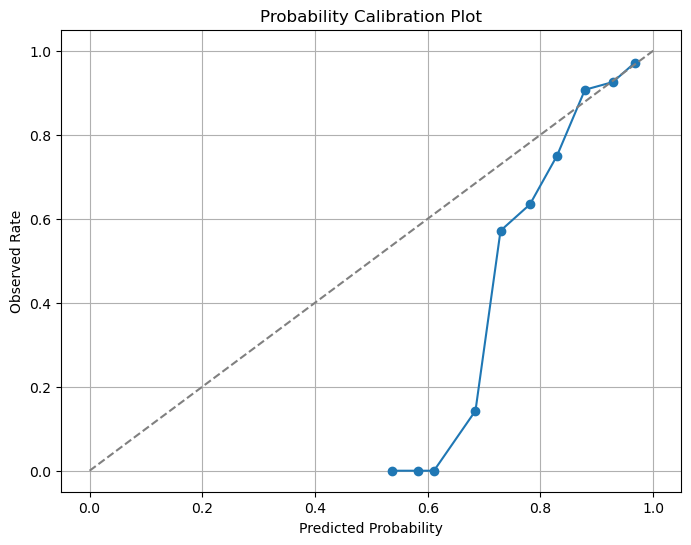

In [274]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(xp_attempts, proba_col='extra_point_make_proba', actual_col='extra_point_good', bins=20)

#### XP Make Proba model performs similar to baseline of choosing the most common class. Because of this, I opted to use empirical success rates binned by division and power-5 conference

In [348]:
power_5 = ['Big Ten', 'Big 12', 'ACC', 'SEC', 'Pac-12']

xp_attempts['offense_division_power_5'] = np.where(
    xp_attempts['offense_conference'].isin(power_5) & (xp_attempts['offense_division'] == "fbs"),
    "fbs_power_5",
    np.where(
        xp_attempts['offense_division'] == "fbs",
        "fbs_non_power_5",
        xp_attempts['offense_division']
    )
)

xp_success_rates = xp_attempts.groupby('offense_division_power_5').agg(
    total_attempts=('extra_point_good', 'size'),
    success_rate=('extra_point_good', 'mean')
).reset_index().sort_values(by='success_rate', ascending=False).rename(
    columns={'offense_division_power_5': 'division'}
).assign(
    success_rate=lambda x: (x['success_rate']).round(5)
)
xp_success_rates

,division,total_attempts,success_rate
1,fbs_power_5,2904,0.95455
0,fbs_non_power_5,2777,0.94707
2,fcs,240,0.87917


In [349]:
xp_success_rates[['division','success_rate']].to_parquet(
    join('../models/raw/try_attempt', 'extra_point_success_rates.parquet'),
    index=False
)

# 3. Two Point Conversion Model
Two point conversion performs poorly, low correlations to features. It fails to significanly outperform a baseline model with always chooses the majority class. Because of this, I went with the simpler route of sampleing from empirical base rates binned by division of offense and defense.

In [351]:
two_pt_attempt_types = ['2pt Conversion', 'Two Point Pass','Two Point Rush']
two_pt_tries = plays[
    plays['play_type'].isin(two_pt_attempt_types) |
    plays['play_text'].str.lower().str.contains("two-point", na=False)
].copy()
two_pt_tries = (
    two_pt_tries
    .merge(
        drives[['id', 'game_id', 'start_offense_score', 'end_offense_score']].rename(
            columns={'id': 'drive_id'}
        ),
        on=['drive_id', 'game_id'],
        how='left'
    )
    .assign(
        try_points_scored = lambda x: x.end_offense_score - x.start_offense_score - 6
    )
    .query('try_points_scored.isin([0, 2])')
)
two_pt_tries = (
    two_pt_tries
    .assign(
        two_pt_try_success = two_pt_tries['try_points_scored'] == 2,
        score_diff_before = two_pt_tries.offense_score - two_pt_tries.defense_score - two_pt_tries.try_points_scored,
        pct_game_played = (((two_pt_tries['period'] - 1) * 15 * 60) + ((15 * 60) - 
                            (two_pt_tries['clock_minutes'] * 60 + two_pt_tries['clock_seconds']))) / (4 * 15 * 60),
        game_seconds_remaining = ((4 * 15 * 60) - ((two_pt_tries['period'] - 1) * 15 * 60 + (15 * 60) - 
                                (two_pt_tries['clock_minutes'] * 60 + two_pt_tries['clock_seconds']))),
    )
    .merge(
        weather[['id','temperature','wind_speed','precipitation','game_indoors']].rename(
            columns={'id': 'game_id'}
        ),
        on='game_id',
        how='left'
    )
    .merge(
        games[['id','season','week','venue_id']].rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'division', 'elo']].rename(columns={
            'team': 'offense', 
            'elo': 'offense_elo',
            'division': 'offense_division'
        }),
        on=['season', 'week', 'offense'],
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'division', 'elo']].rename(columns={
            'team': 'defense', 
            'elo': 'defense_elo',
            'division': 'defense_division'
        }),
        on=['season', 'week', 'defense'],
        how='left'
    )
    .merge(
        venues[['id', 'elevation']].rename(columns={'id': 'venue_id'}),
        on='venue_id',
        how='left'
    ).drop(columns=['venue_id'])
)
two_pt_tries['elevation'] = two_pt_tries['elevation'].astype(float)

two_pt_tries = (
    two_pt_tries
    .assign(
        wind_speed = np.where(two_pt_tries.game_indoors, 0, two_pt_tries.wind_speed.fillna(int(two_pt_tries.wind_speed.mean()))),
        elevation = two_pt_tries.elevation.fillna(int(two_pt_tries.elevation.astype(float).mean())),
        precipitation = np.where(two_pt_tries.game_indoors, 0, two_pt_tries.precipitation.fillna(int(two_pt_tries.precipitation.mean()))),
        temperature = np.where(two_pt_tries.game_indoors, 70, two_pt_tries.temperature.fillna(int(two_pt_tries.temperature.mean()))),
        must_make_to_stay_alive = np.where(
            (two_pt_tries.score_diff_before == -2) & (two_pt_tries.game_seconds_remaining <= 120),
            True,
            False
        ),
        two_pt_ties_game = np.where(
            two_pt_tries.score_diff_before == -2,
            True,
            False
        ),
        two_pt_for_lead = np.where(
            two_pt_tries.score_diff_before == -1,
            True,
            False
        ),
        is_home_team = np.where(
            two_pt_tries.offense == two_pt_tries.home,
            True,
            False
        ),
        diff_time_ratio = two_pt_tries['score_diff_before'] * np.exp(4 * (3600 - two_pt_tries['game_seconds_remaining']) / 3600),
        run_or_pass = np.where(
            two_pt_tries['play_text'].str.lower().str.contains(' rush ', na=False) |
            two_pt_tries['play_text'].str.lower().str.contains(' run ', na=False) |
            two_pt_tries['play_text'].str.lower().str.contains(' rushed', na=False) |
            two_pt_tries['play_text'].str.lower().str.contains(' rushing', na=False) |
            (two_pt_tries['play_type'] == 'Two Point Rush'),
            'rush',
            np.where(
                two_pt_tries['play_text'].str.lower().str.contains(' pass ', na=False) |
                two_pt_tries['play_text'].str.lower().str.contains(' pass.', na=False) |
                two_pt_tries['play_text'].str.lower().str.contains(' pass,', na=False) |
                (two_pt_tries['play_type'] == 'Two Point Pass'),
                'pass',
                'unknown'
            )
        )
    )
    .drop(columns=['game_indoors'])
    .query('period.isin([1, 2, 3, 4]) and 0 <= pct_game_played <= 1') # No overtime attempts
)

two_pt_tries.query('run_or_pass != "unknown"', inplace=True)

two_pt_tries['pass_attempt'] = np.where(
    two_pt_tries['run_or_pass'] == 'pass', True, False
)

two_pt_tries.head()

,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,start_offense_score,end_offense_score,try_points_scored,two_pt_try_success,score_diff_before,pct_game_played,game_seconds_remaining,temperature,wind_speed,precipitation,season,week,offense_division,offense_elo,defense_division,defense_elo,elevation,must_make_to_stay_alive,two_pt_ties_game,two_pt_for_lead,is_home_team,diff_time_ratio,run_or_pass,pass_attempt
0,332430194048,33243019404,332430194,4,6,Ohio State,Big Ten,16,Buffalo,Ohio State,Buffalo,Mid-American,0,1,2.0,2.0,97,3,-1,-1,0,True,2pt Conversion,"Two-point conversion attempt, Kenny Guiton pas...",NaN,7,5,8,16,2,True,14,0.131944,3125,82.9,8.1,0.0,2013,1,fbs,3021.024782,fbs,1260.643166,216.677032,False,False,False,True,23.732255,pass,True
1,332430194022,33243019402,332430194,2,5,Ohio State,Big Ten,8,Buffalo,Ohio State,Buffalo,Mid-American,0,1,2.0,2.0,97,3,-1,-1,0,True,2pt Conversion,"Two-point conversion attempt, Kenny Guiton rus...",NaN,10,40,0,8,2,True,6,0.072222,3340,82.9,8.1,0.0,2013,1,fbs,3021.024782,fbs,1260.643166,216.677032,False,False,False,True,8.009660,rush,False
2,332430356115,33243035615,332430356,15,10,Illinois,Big Ten,25,Southern Illinois,Illinois,Southern Illinois,MVFC,7,2,1.0,1.0,97,3,-1,-1,0,True,2pt Conversion,"Two-point conversion attempt, Tim Russell pass...",NaN,0,17,17,25,2,True,16,0.495278,1817,82.0,3.4,0.0,2013,1,fbs,1734.549842,fcs,1553.230400,223.247162,False,False,False,True,116.012719,pass,True
3,333622306199,33362230618,333622306,18,6,Michigan,Big Ten,14,Kansas State,Kansas State,Michigan,Big 12,31,4,2.0,2.0,3,3,-1,-1,0,True,2pt Conversion,"Two-point conversion attempt, Jeremy Gallon pa...",NaN,1,15,6,14,2,True,-19,0.979167,75,61.0,7.0,0.0,2013,1,fbs,2687.727457,fbs,2878.346980,360.156952,False,False,False,False,-954.421737,pass,True
4,340010239173,34001023924,340010239,24,8,Baylor,Big 12,28,UCF,Baylor,UCF,American Athletic,28,3,3.0,3.0,97,3,-1,-1,0,True,2pt Conversion,"Two-point conversion attempt, Bryce Petty rush...",NaN,10,18,20,28,2,True,-2,0.578333,1518,70.0,0.0,0.0,2013,1,fbs,2625.137468,fbs,2171.347997,276.000000,False,True,False,True,-20.216124,rush,False


In [329]:
two_pt_tries.groupby('run_or_pass').agg(
    total_attempts=('two_pt_try_success', 'size'),
    success_rate=('two_pt_try_success', 'mean')
).reset_index().sort_values(by='success_rate', ascending=False).rename(
    columns={'run_or_pass': 'run_or_pass'}
).assign(
    success_rate=lambda x: (x['success_rate']).round(5)
)

,run_or_pass,total_attempts,success_rate
1,rush,1981,0.46441
0,pass,1618,0.39988


In [333]:
features = [
    'score_diff_before', 
    'pct_game_played',
    'game_seconds_remaining',
    'temperature',
    'wind_speed', 
    'precipitation', 
    'offense_elo', 
    'elevation',
    'must_make_to_stay_alive', 
    'two_pt_ties_game', 
    'two_pt_for_lead',
    'is_home_team', 
    'diff_time_ratio',
    'pass_attempt'
]

data = two_pt_tries[features + ['two_pt_try_success']].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data['two_pt_try_success']
)
test_x, test_y = test_data[features], test_data['two_pt_try_success']

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[features], 
    train_data['two_pt_try_success'], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data['two_pt_try_success']
)

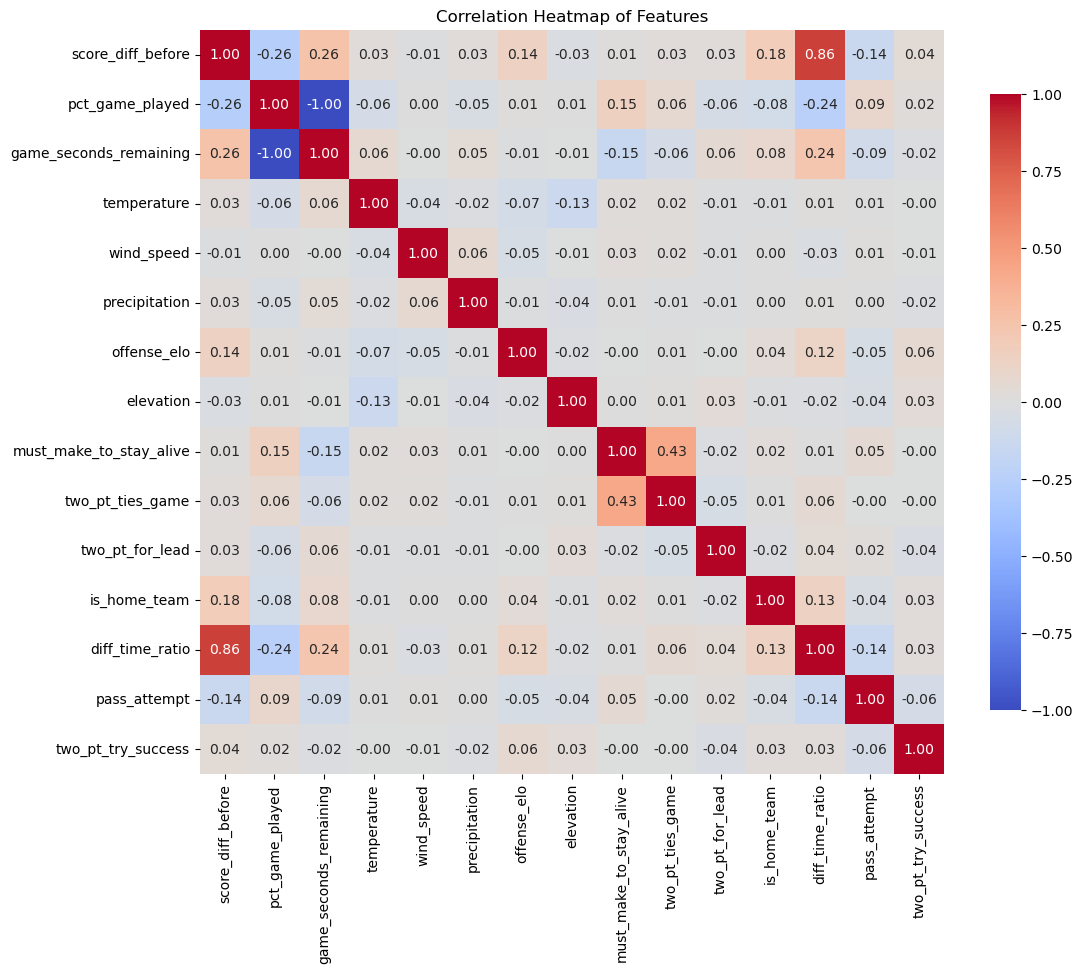

In [334]:
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [337]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

feature_names = [
    'score_diff_before', 
    'pct_game_played',
    'game_seconds_remaining',
    'temperature',
    'wind_speed', 
    'precipitation', 
    'offense_elo', 
    'elevation',
    'must_make_to_stay_alive', 
    'two_pt_ties_game', 
    'two_pt_for_lead',
    'is_home_team', 
    'diff_time_ratio',
    'pass_attempt'
]

# interaction_constraints = [
#     ['will_need_two_pt_to_tie', 'pct_game_played'],
#     ['two_point_to_lead', 'pct_game_played'],
#     ['two_point_to_tie', 'pct_game_played'],
# ]

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        # "interaction_constraints": interaction_constraints,
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="xp_attempts_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    # 'interaction_constraints': interaction_constraints,
    'eval_metric': 'logloss',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

# Evaluate on train set
train_preds = final_model.predict(dtrain)
print(f"Final train log loss: {log_loss(train_y, train_preds):0.3f}")

# Evaluate on validation set
valid_preds = final_model.predict(dvalid)
print(f"Final validation log loss: {log_loss(valid_y, valid_preds):0.3f}")

# Evaluate on test set
dtest = xgb.DMatrix(test_x, label= test_y)
test_preds = final_model.predict(dtest)
print(f"Final test log loss: {log_loss(test_y, test_preds):0.3f}")

Number of boosted rounds: 27
Final train log loss: 0.648
Final validation log loss: 0.680
Final test log loss: 0.682


In [336]:
p = two_pt_tries.two_pt_try_success.value_counts(normalize=True).values[0]
baseline_log_loss = -(p * np.log(p) + (1 - p) * np.log(1 - p))
print(f"Baseline log loss: {baseline_log_loss:0.3f}")

Baseline log loss: 0.685


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_48013/10610399.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


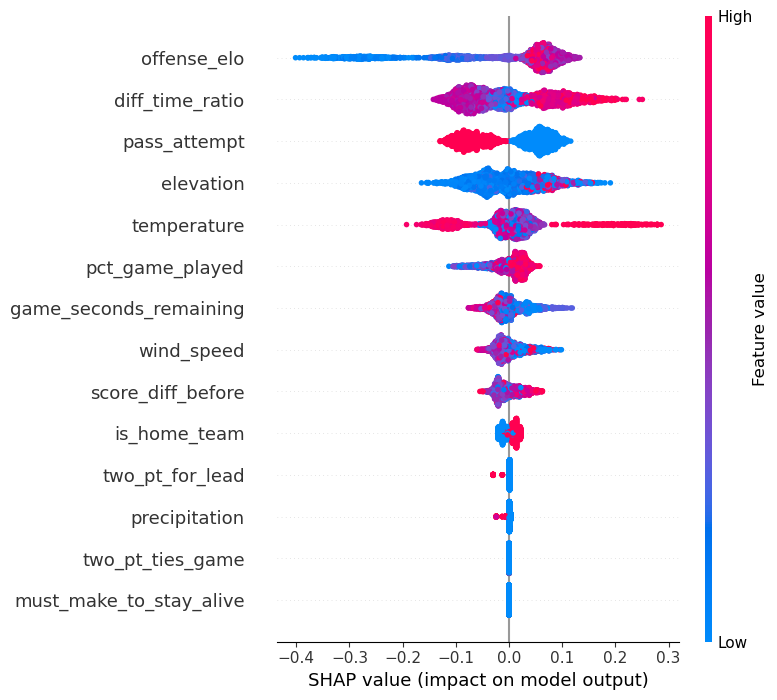

In [338]:
import shap
background = train_data[feature_names]
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, 
                 background, 
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

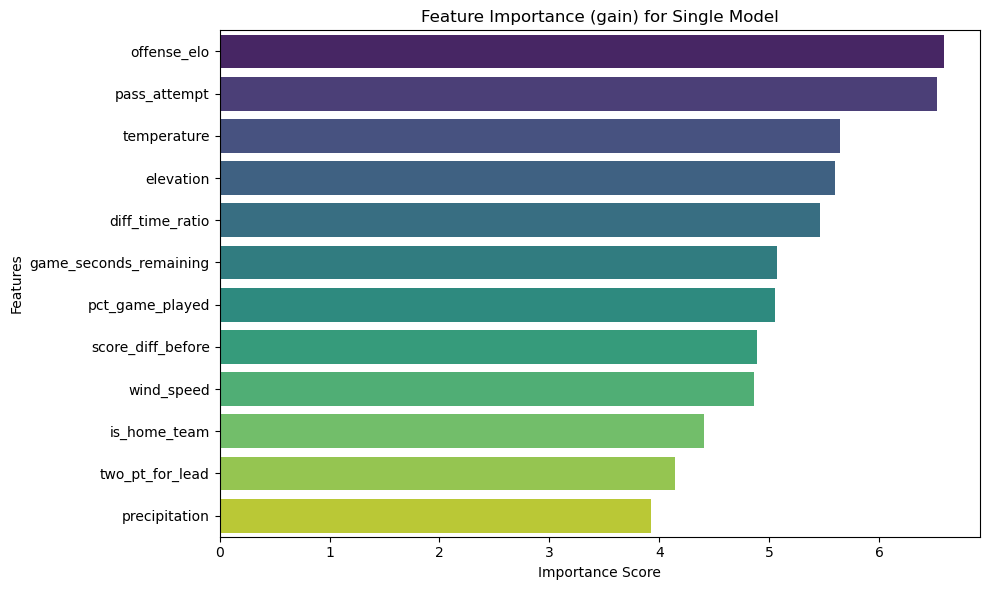

In [339]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [341]:
# predict extra_point_attempt_proba for all plays
two_pt_tries['two_pt_conversion_proba'] = final_model.predict(xgb.DMatrix(two_pt_tries[feature_names]))

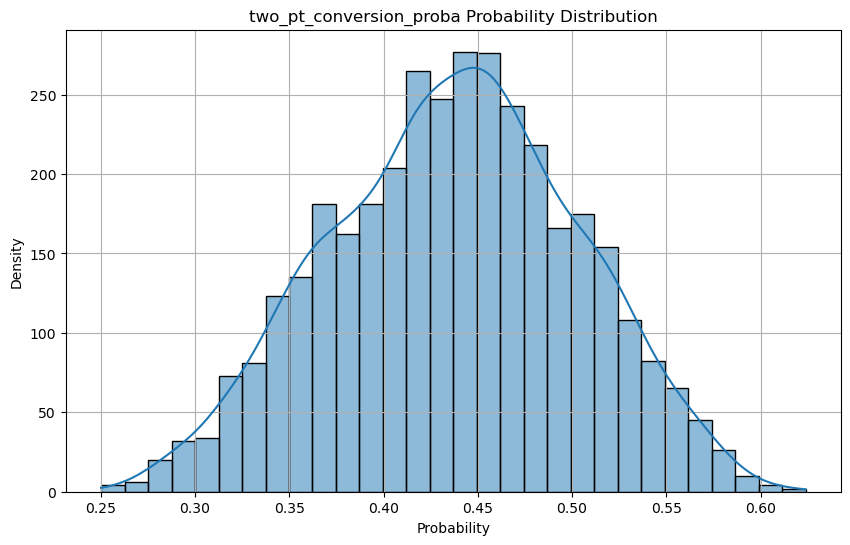

In [342]:
# plot win probability
def plot_wp(df, col):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(two_pt_tries, col='two_pt_conversion_proba')

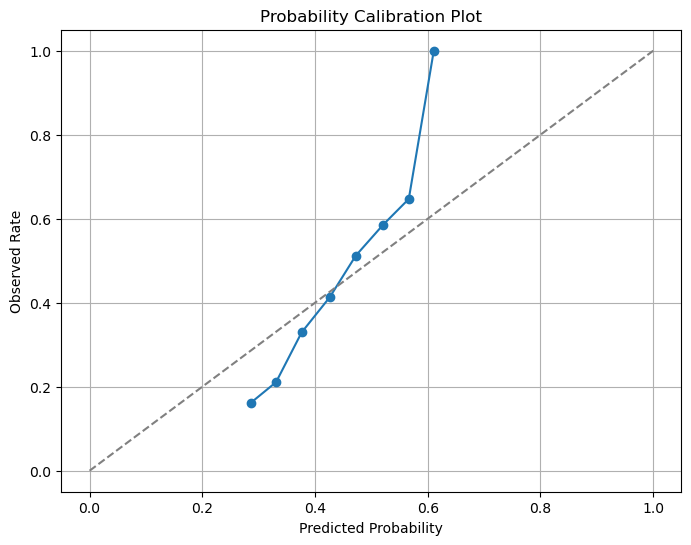

In [343]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(two_pt_tries, proba_col='two_pt_conversion_proba', actual_col='two_pt_try_success', bins=20)

#### Two-Point Conversion Proba model performs similar to baseline of choosing the most common class. Because of this, I opted to use empirical success rates binned by division of offense and defense

In [359]:
power_5 = ['Big Ten', 'Big 12', 'ACC', 'SEC', 'Pac-12']

two_pt_tries['offense_division_power_5'] =  np.where(
    two_pt_tries['offense_conference'].isin(power_5) & (two_pt_tries['offense_division'] == "fbs"),
    "fbs_power_5",
    np.where(
        two_pt_tries['offense_division'] == "fbs",
        "fbs_non_power_5",
        two_pt_tries['offense_division']
    )
)
two_pt_tries['defense_division_power_5'] =  np.where(
    two_pt_tries['defense_conference'].isin(power_5) & (two_pt_tries['defense_division'] == "fbs"),
    "fbs_power_5",
    np.where(
        two_pt_tries['defense_division'] == "fbs",
        "fbs_non_power_5",
        two_pt_tries['defense_division']
    )
)

two_pt_success_rates = two_pt_tries.groupby(['offense_division_power_5', 'defense_division_power_5']).agg(
    total_attempts=('two_pt_try_success', 'size'),
    success_rate=('two_pt_try_success', 'mean')
).reset_index().sort_values(by='success_rate', ascending=False).assign(
    success_rate=lambda x: (x['success_rate']).round(5)
).query('offense_division_power_5.isin(["fbs_power_5", "fbs_non_power_5", "fcs"]) and '
        'defense_division_power_5.isin(["fbs_power_5", "fbs_non_power_5", "fcs"])')
two_pt_success_rates

,offense_division_power_5,defense_division_power_5,total_attempts,success_rate
5,fbs_power_5,fcs,45,0.48889
2,fbs_non_power_5,fcs,80,0.48750
3,fbs_power_5,fbs_non_power_5,147,0.46939
0,fbs_non_power_5,fbs_non_power_5,1222,0.46645
4,fbs_power_5,fbs_power_5,1252,0.45128
6,fcs,fbs_non_power_5,78,0.42308
1,fbs_non_power_5,fbs_power_5,155,0.40645
8,fcs,fcs,570,0.34035
7,fcs,fbs_power_5,37,0.24324


In [364]:
two_pt_success_rates = two_pt_tries.groupby(['offense_division', 'defense_division']).agg(
    total_attempts=('two_pt_try_success', 'size'),
    success_rate=('two_pt_try_success', 'mean')
).reset_index().sort_values(by='success_rate', ascending=False).assign(
    success_rate=lambda x: (x['success_rate']).round(5)
).query('offense_division.isin(["fbs", "fcs"]) and '
        'defense_division.isin(["fbs", "fcs"])')
two_pt_success_rates

,offense_division,defense_division,total_attempts,success_rate
1,fbs,fcs,125,0.48800
0,fbs,fbs,2776,0.45641
2,fcs,fbs,115,0.36522
3,fcs,fcs,570,0.34035


In [350]:
two_pt_tries.two_pt_try_success.value_counts(normalize=True)

two_pt_try_success
False    0.564601
True     0.435399
Name: proportion, dtype: float64

In [365]:
two_pt_success_rates[['offense_division','defense_division','success_rate']].to_parquet(
    join('../models/raw/try_attempt', 'two_point_success_rates.parquet'),
    index=False
)